# CSTR Reaction Kinetics Example for Physics-Informed Neural Network (PINN)

The purpose of this notebook is to explore another methodology of solving the same problem proposed in the original notebook of a CSTR system with reaction kinetics defined as $A + B \leftrightarrow C$. For this notebook, instead of using the Embedded GP Approximation approach to the methodology, we will use a Physics-Informed Neural Network (PINN) where we can change the loss function to match our case, similar to the way we changed the likelihood function in the Embedded GP Approximation approach.

In [6]:
# Import relevant libraries

# For data processing
import pandas as pd
import numpy as np

# For visualization
import matplotlib.pyplot as plt

# For PyTorch
import torch
import torch.nn as nn
import torch.optim as optim

Import the data.

In [7]:
data = pd.read_csv('data/CSTR_data_with_noise.csv')

# Data
Inv_temp_np = data['Temperature_Inv'].to_numpy()
C_CO2_np = data['C_CO2'].to_numpy()
C_Sites_np = data['C_Sites'].to_numpy()
C_CO2_ADS_np = data['C_CO2_ADS'].to_numpy()

# Outcome variable
r_co2_np = data['r_co2'].to_numpy()

Train the model using the physics of the reaction rate kinetics.  They are noted below for reference.

$$
-r_{CO_{2}} = k_{f1} \cdot C_{CO_2} \cdot Site - k_{b1} \cdot C_{CO_2 \:ADS}
$$



In [8]:
# Convert data to PyTorch tensors
x_train = torch.from_numpy(Inv_temp_np).float().unsqueeze(1)
y_train = torch.from_numpy(r_co2_np).float().unsqueeze(1)
C_CO2 = torch.from_numpy(C_CO2_np).float().unsqueeze(1)
C_Sites = torch.from_numpy(C_Sites_np).float().unsqueeze(1)
C_CO2_ADS = torch.from_numpy(C_CO2_ADS_np).float().unsqueeze(1)

# Define the neural network model
class ExpApproximationModel(nn.Module):
    def __init__(self):
        super(ExpApproximationModel, self).__init__()
        self.fc1 = nn.Linear(1, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 2)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Define custom mean squared error loss function
class CustomMSELoss(nn.Module):
    def __init__(self):
        super(CustomMSELoss, self).__init__()

    def forward(self, output, target, C_CO2_batch, C_Sites_batch, C_CO2_ADS_batch):
        output1, output2 = output[:, 0], output[:, 1]
        total_output = -(torch.exp(-(output1)) * C_CO2_batch.t() * C_Sites_batch.t() - torch.exp(-(output2)) * C_CO2_ADS_batch.t())
        return torch.mean((total_output - target.squeeze()) ** 2)

# Initialize the model, custom criterion, and optimizer
model = ExpApproximationModel()
criterion = CustomMSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

# Create data loader
train_dataset = torch.utils.data.TensorDataset(x_train, y_train, C_CO2, C_Sites, C_CO2_ADS)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

# Max for saving model
best_loss = float('inf')

# Training the model
num_epochs = 500
for epoch in range(num_epochs):
    for inputs, targets, C_CO2_batch, C_Sites_batch, C_CO2_ADS_batch in train_loader:
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets, C_CO2_batch, C_Sites_batch, C_CO2_ADS_batch)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        outputs = model(x_train)
        loss = criterion(outputs, y_train, C_CO2, C_Sites, C_CO2_ADS)
    
    # Save the model if the validation loss is the best we've seen so far
    if loss < best_loss:
        best_loss = loss
        torch.save(model.state_dict(), 'models/PyTorch_CSTR_Kinetics.pth')
        print(f'New best model saved at epoch {epoch+1} with loss: {loss:.6f}')
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

New best model saved at epoch 1 with loss: 0.000042
New best model saved at epoch 8 with loss: 0.000040
Epoch [10/500], Loss: 0.000043
New best model saved at epoch 20 with loss: 0.000039
Epoch [20/500], Loss: 0.000039
New best model saved at epoch 24 with loss: 0.000038
New best model saved at epoch 27 with loss: 0.000038
Epoch [30/500], Loss: 0.000039
Epoch [40/500], Loss: 0.000042
New best model saved at epoch 43 with loss: 0.000038
Epoch [50/500], Loss: 0.000039
Epoch [60/500], Loss: 0.000041
Epoch [70/500], Loss: 0.000039
Epoch [80/500], Loss: 0.000058
Epoch [90/500], Loss: 0.000042
New best model saved at epoch 98 with loss: 0.000038
Epoch [100/500], Loss: 0.000042
New best model saved at epoch 105 with loss: 0.000038
Epoch [110/500], Loss: 0.000040
New best model saved at epoch 115 with loss: 0.000038
Epoch [120/500], Loss: 0.000042
New best model saved at epoch 128 with loss: 0.000038
Epoch [130/500], Loss: 0.000040
New best model saved at epoch 134 with loss: 0.000038
New best

In [9]:
# Load the state dictionary
model.load_state_dict(torch.load('models/PyTorch_CSTR_Kinetics.pth'))

# Evaluate the model
model.eval()
with torch.no_grad():
    x_test = np.linspace(min(Inv_temp_np), max(Inv_temp_np), 1000)
    inputs = torch.from_numpy(x_test).float().unsqueeze(1)
    predictions = model(inputs).squeeze().numpy()

C:\Users\Michael\AppData\Local\Temp\ipykernel_14772\3114140538.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/PyTorch_CSTR_Kine

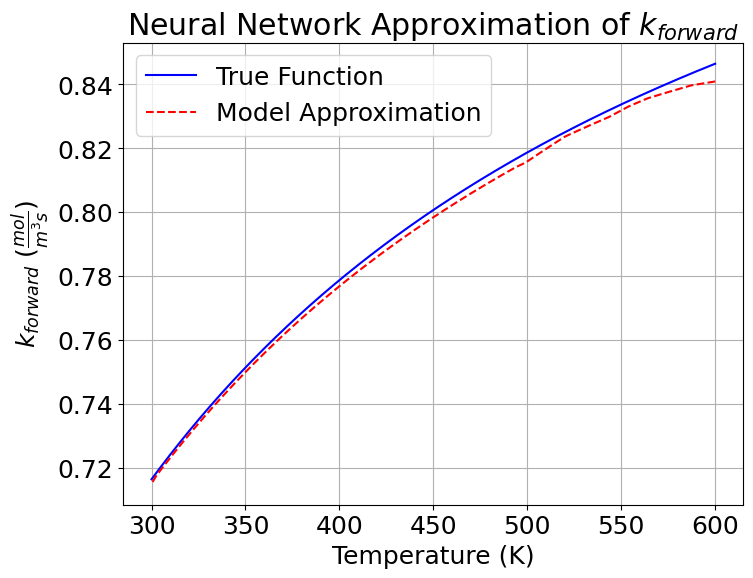

In [10]:
# Plot the results
plt.rcParams['font.size'] = 18
plt.figure(figsize=(8, 6))
plt.plot(x_test**-1, np.exp(-100*x_test), label='True Function', color='blue')
plt.plot(x_test**-1, np.exp(-predictions[:,0]), label='Model Approximation', color='red', linestyle='--')
plt.xlabel('Temperature (K)')
plt.ylabel('$k_{forward}$ (' + r'$\frac{mol}{m^3s}$)')
plt.title('Neural Network Approximation of $k_{forward}$')
plt.legend()
plt.grid(True)
plt.show()

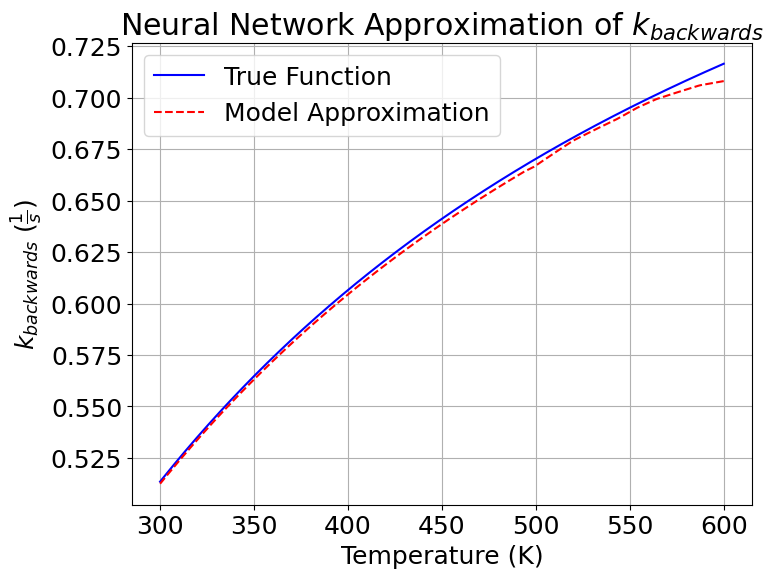

In [11]:
# Plot the results
plt.rcParams['font.size'] = 18
plt.figure(figsize=(8, 6))
plt.plot(x_test**-1, np.exp(-200*x_test), label='True Function', color='blue')
plt.plot(x_test**-1, np.exp(-predictions[:,1]), label='Model Approximation', color='red', linestyle='--')
plt.xlabel('Temperature (K)')
plt.ylabel('$k_{backwards}$ (' + r'$\frac{1}{s}$)')
plt.title('Neural Network Approximation of $k_{backwards}$')
plt.legend()
plt.grid(True)
plt.show()

This confirms that PINNs can be used in this method to solve for our reaction kinetics.